In [69]:
!pip install cvxopt

In [70]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from scipy.optimize import minimize

In [71]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]  # 5 Large-cap Tech (2025 scenario)
start_date = "2020-01-01"
end_date = "2025-01-01"

plots_dir = os.path.join(os.getcwd(), "plots")
os.makedirs(plots_dir, exist_ok=True)

In [72]:
def fetch_data(tickers, start, end):
    """Download price data from yfinance, selecting 'Close' column only.\n    Create a copy before dropping rows to avoid SettingWithCopyWarning."""
    raw_data = yf.download(tickers, start=start, end=end, progress=False)

    
    data = raw_data[["Close"]].copy()  # or just raw_data["Close"].copy()

    
    data.dropna(how="all", inplace=True)

    #
    if len(tickers) == 1:
        data = data["Close"].to_frame()

    return data["Close"]

prices = fetch_data(tickers, start_date, end_date)
print(prices.info())
print(prices.head())
print(daily_returns.describe())
daily_returns = prices.pct_change().dropna()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2020-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1258 non-null   float64
 1   AMZN    1258 non-null   float64
 2   GOOGL   1258 non-null   float64
 3   MSFT    1258 non-null   float64
 4   TSLA    1258 non-null   float64
dtypes: float64(5)
memory usage: 59.0 KB
None
Ticker           AAPL       AMZN      GOOGL        MSFT       TSLA
Date                                                              
2020-01-02  72.716080  94.900497  68.108383  153.323288  28.684000
2020-01-03  72.009125  93.748497  67.752075  151.414108  29.534000
2020-01-06  72.582916  95.143997  69.557945  151.805481  30.102667
2020-01-07  72.241539  95.343002  69.423592  150.421356  31.270666
2020-01-08  73.403641  94.598503  69.917725  152.817337  32.809334
Ticker         AAPL         AMZN        GOOGL         MSFT         TSLA
count   1257.000000  1257.0000

In [73]:
mean_daily_returns = daily_returns.mean()
annual_returns = mean_daily_returns * 252
cov_matrix = daily_returns.cov() * 252

print(">>> Annual Returns:")
print(annual_returns)
print(">>> Covariance Matrix:")
print(cov_matrix)


>>> Annual Returns:
Ticker
AAPL     0.297892
AMZN     0.232658
GOOGL    0.257607
MSFT     0.248931
TSLA     0.755347
dtype: float64
>>> Covariance Matrix:
Ticker      AAPL      AMZN     GOOGL      MSFT      TSLA
Ticker                                                  
AAPL    0.100354  0.067469  0.066809  0.072297  0.102729
AMZN    0.067469  0.129341  0.075643  0.074418  0.104519
GOOGL   0.066809  0.075643  0.105618  0.073956  0.087154
MSFT    0.072297  0.074418  0.073956  0.093008  0.091479
TSLA    0.102729  0.104519  0.087154  0.091479  0.451336


In [74]:
def portfolio_performance(weights, returns, cov):
    port_return = np.sum(returns * weights)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return port_return, port_vol


def neg_sharpe_ratio(weights, returns, cov, risk_free=0.02):
    p_ret, p_vol = portfolio_performance(weights, returns, cov)
    return -((p_ret - risk_free) / p_vol)

test_weights = np.ones(len(annual_returns)) / len(annual_returns)
test_ret, test_vol = portfolio_performance(test_weights, annual_returns, cov_matrix)
test_sharpe = -neg_sharpe_ratio(test_weights, annual_returns, cov_matrix, risk_free=0.02)

print(">>> Testing uniform weights performance:")
print(f"Return={test_ret:.2%}, Volatility={test_vol:.2%}, Sharpe={test_sharpe:.2f}")


>>> Testing uniform weights performance:
Return=35.85%, Volatility=31.70%, Sharpe=1.07


In [75]:
def max_sharpe_allocation(returns, cov, risk_free=0.02):
    from functools import partial
    num_assets = len(returns)
    init_guess = np.ones(num_assets) / num_assets
    bounds = tuple((0.0, 1.0) for _ in range(num_assets))
    constraints = ( {"type": "eq", "fun": lambda w: np.sum(w) - 1}, )

    result = minimize(
        fun=partial(neg_sharpe_ratio, returns=returns, cov=cov, risk_free=risk_free),
        x0=init_guess,
        bounds=bounds,
        constraints=constraints,
        method="SLSQP"
    )
    return result

max_sharpe_result = max_sharpe_allocation(annual_returns, cov_matrix)
ms_weights = max_sharpe_result.x
ms_ret, ms_vol = portfolio_performance(ms_weights, annual_returns, cov_matrix)
ms_sharpe = (ms_ret - 0.02) / ms_vol

In [83]:
def minimize_volatility(weights, returns, cov):
    return portfolio_performance(weights, returns, cov)[1]


def efficient_frontier(returns, cov, returns_range):
    num_assets = len(returns)
    bounds = [(0.0, 1.0)] * num_assets
    frontier = []

    for ret_target in returns_range:
        constraints = (
            {"type": "eq", "fun": lambda w: np.sum(w) - 1},
            {"type": "eq", "fun": lambda w: portfolio_performance(w, returns, cov)[0] - ret_target}
        )
        res = minimize(
            minimize_volatility,
            x0=np.ones(num_assets)/num_assets,
            args=(returns, cov),
            bounds=bounds,
            constraints=constraints,
            method="SLSQP"
        )
        if res.success:
            frontier.append((ret_target, res.fun))
    return frontier

min_ret, max_ret = annual_returns.min(), annual_returns.max()
returns_grid = np.linspace(min_ret, max_ret, 30)
frontier_points = efficient_frontier(annual_returns, cov_matrix, returns_grid)

In [85]:
def simulate_random_weights(num_assets): 
    weights = np.random.random(num_assets) 
    weights /= np.sum(weights) 

    return weights 

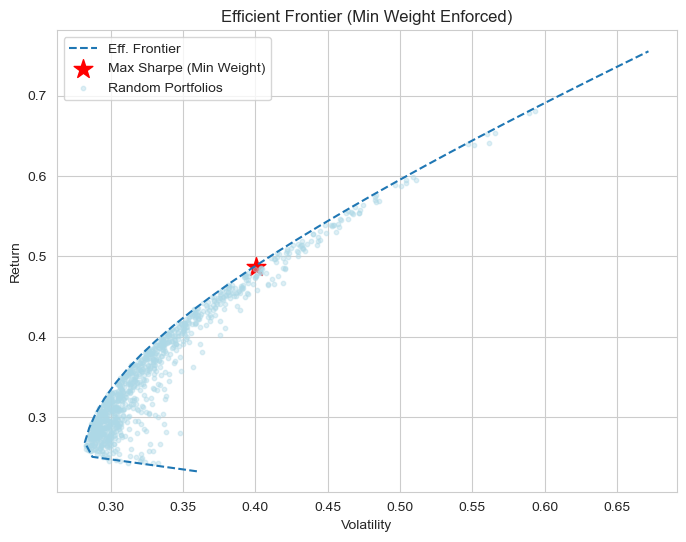

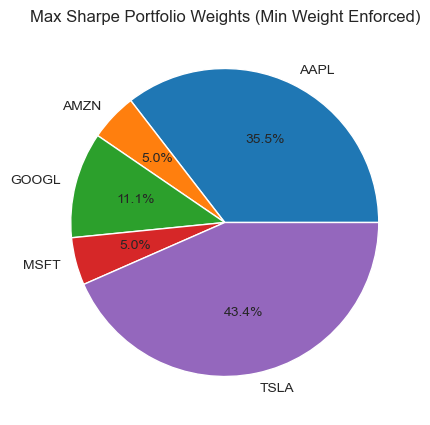

In [87]:
sns.set_style("whitegrid")


vols = [v for _, v in frontier_points]
rets = [r for r, _ in frontier_points]

plt.figure(figsize=(8,6))
plt.plot(vols, rets, "--", label="Eff. Frontier")


plt.scatter(ms_vol2, ms_ret2, c="red", marker="*", s=200, label="Max Sharpe (Min Weight)")


n_samp = 1000
rand_w = np.random.dirichlet(np.ones(len(annual_returns)), size=n_samp)
rand_rets = []
rand_vols = []
for w in rand_w:
    pr, pv = portfolio_performance(w, annual_returns, cov_matrix)
    rand_rets.append(pr)
    rand_vols.append(pv)

plt.scatter(rand_vols, rand_rets, c="lightblue", alpha=0.4, s=10, label="Random Portfolios")
plt.title("Efficient Frontier (Min Weight Enforced)")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.legend()


ef_plot = os.path.join(plots_dir, "efficient_frontier_minweight.png")
plt.savefig(ef_plot, dpi=300, bbox_inches="tight")
plt.show()


plt.figure(figsize=(5,5))
plt.pie(ms_weights_final, labels=annual_returns.index, autopct="%.1f%%")
plt.title("Max Sharpe Portfolio Weights (Min Weight Enforced)")
pie_path = os.path.join(plots_dir, "max_sharpe_pie_minweight.png")
plt.savefig(pie_path, dpi=300, bbox_inches="tight")
plt.show()


In [89]:
if __name__ == "__main__":
    
    MIN_WEIGHT = 0.05
    num_assets = len(annual_returns)
    bounds = [(MIN_WEIGHT, 1.0)] * num_assets
    constraints = ({"type": "eq", "fun": lambda w: np.sum(w) - 1},)

    from functools import partial
    from scipy.optimize import minimize

    def max_sharpe_allocation_with_min(returns, cov, risk_free=0.02):
        init_guess = np.ones(num_assets) / num_assets
        result = minimize(
            fun=partial(neg_sharpe_ratio, returns=returns, cov=cov, risk_free=risk_free),
            x0=init_guess,
            bounds=bounds,
            constraints=constraints,
            method="SLSQP"
        )
        return result

    
    result_min_weight = max_sharpe_allocation_with_min(annual_returns, cov_matrix)
    if not result_min_weight.success:
        print("Max Sharpe with min weight failed. Using the original solution.")
        ms_weights_final = ms_weights 
    else:
        ms_weights_final = result_min_weight.x

    ms_ret2, ms_vol2 = portfolio_performance(ms_weights_final, annual_returns, cov_matrix)
    ms_sharpe2 = (ms_ret2 - 0.02) / ms_vol2

    print("\n===== Enhanced Quant Portfolio Optimization =====")
    print(f"Tickers: {tickers}")
    print(f"Date Range: {start_date} to {end_date}")

    print("\nOptimal Weights (Min Weight = 5%):")
    for t, w in zip(tickers, ms_weights_final):
        print(f"  {t}: {w*100:.2f}%")

    print(f"\nAnnual Return: {ms_ret2*100:.2f}%")
    print(f"Annual Volatility: {ms_vol2*100:.2f}%")
    print(f"Sharpe Ratio: {ms_sharpe2:.2f}")

    
    capital = 100000
    latest_prices = prices.iloc[-1] 
   
    allocations = ms_weights_final * capital
    
    shares = (allocations / latest_prices).apply(np.floor)

    print("\n=== Capital Deployment ===")
    for t, w, sh, p in zip(tickers, ms_weights_final, shares, latest_prices):
        invested = sh * p
        print(f"  {t}: weight={w*100:.2f}%, shares={int(sh)}, "
              f"price=${p:.2f}, invested=${invested:.2f}")

    total_invested = sum(shares * latest_prices)
    print(f"\nTotal capital used: ${total_invested:.2f}")
    print(f"Unused cash: ${capital - total_invested:.2f}")
    print("\nPlots saved to 'plots/' folder.")
    print("Done.")


  


===== Enhanced Quant Portfolio Optimization =====
Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
Date Range: 2020-01-01 to 2025-01-01

Optimal Weights (Min Weight = 5%):
  AAPL: 35.45%
  MSFT: 5.00%
  GOOGL: 11.13%
  AMZN: 5.00%
  TSLA: 43.42%

Annual Return: 48.63%
Annual Volatility: 40.05%
Sharpe Ratio: 1.16

=== Capital Deployment ===
  AAPL: weight=35.45%, shares=141, price=$250.14, invested=$35270.44
  MSFT: weight=5.00%, shares=22, price=$219.39, invested=$4826.58
  GOOGL: weight=11.13%, shares=58, price=$189.08, invested=$10966.77
  AMZN: weight=5.00%, shares=11, price=$420.66, invested=$4627.22
  TSLA: weight=43.42%, shares=107, price=$403.84, invested=$43210.88

Total capital used: $98901.89
Unused cash: $1098.11

Plots saved to 'plots/' folder.
Done.


C:\Users\ChazinBrahma\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
